# Publishing Figures - Multi Kappa
This notebook is for generating extratropic specific plots, combining all $\kappa$ simulations.

In [2]:
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import clausius_clapeyron_factor, sphum_sat, moist_static_energy
from isca_tools.convection.base import convection_neutral_profile, lcl_temp_bolton, dry_profile_pressure, lapse_moist, lapse_dry
from isca_tools.utils.constants import L_v, c_p, g, R
from isca_tools.utils.stats import z_score_from_confidence_interval
from isca_tools.utils import area_weight_mean_lat, area_weighting
from isca_tools.thesis.adiabat_theory import (get_delta_temp_quant_theory, get_delta_mse_mod_anom_theory,
                                              get_delta_temp_quant_theory_simple, decompose_temp_adiabat_anomaly, get_delta_temp_quant_theory_simple2)
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
import os
import numpy_indexed
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

2024-05-03 10:30:07,896 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [3]:
# Load dataset
var_keep = ['temp', 'sphum', 'height', 'convflag', 'klzbs']
# var_keep = ['temp', 'sphum', 'height']
exp_dir = 'tau_sweep/aquaplanet/depth=1/'
# exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [dir for dir in os.listdir(os.path.join(os.environ['GFDL_DATA'],exp_dir)) if dir[0]=='k']
exp_names.sort()
# exp_names = exp_names[2:-1]     # get rid of coldest 2 and warmest simulation as don't work well
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use]
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
tau_lw = np.asarray(tau_lw)
p_surface = float(ds[0].pfull[-1]) * 100

100%|██████████| 8/8 [00:16<00:00,  2.05s/it]


In [4]:
# Sigma levels
np.convolve(namelist['vert_coordinate_nml']['bk'], np.ones(2)/2, 'valid')

array([0.00588325, 0.0157172 , 0.02559615, 0.04003275, 0.06023775,
       0.08735865, 0.1223205 , 0.16566145, 0.21739335, 0.2769161 ,
       0.3430068 , 0.4138911 , 0.4873889 , 0.5611121 , 0.6326847 ,
       0.6999534 , 0.7611607 , 0.8150635 , 0.8609897 , 0.898836  ,
       0.92901895, 0.95239485, 0.9701652 , 0.9837833 , 0.99487445])

## Get datasets
Get one dataset for each $\kappa$, combining the desired latitudes: `ds_all`. This combines all or just the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [5]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [185]:
# Compute Global Average Surface Temperature and get near surface temperature data
# Use all data after 2 years, as clearly converged from the above spin up plot
use_time_start = 360*2
pressure_ft = 500           # Desired approximate pressure of free troposphere (hPa)

# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90
# region = 'Global'
# lat_min = 0
# lat_max = 90

# Chose whether to only consider summer days or consider all days
# season = 'all'
season = 'summer'
# season = 'winter'
if season == 'summer':
    if region == 'tropics':
        season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}   
    else:
        season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    if region == 'tropics':
        season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]} 

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')      # only keep the surface values - get rid of pfull coordinate
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)

        if season == 'summer' or season == 'winter':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(lat_min, lat_max)) 
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-lat_max, -lat_min))  
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)

ind_surf = 0
ind_ft = 1
p_surface = float(ds_all[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds_all[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)

100%|██████████| 8/8 [01:28<00:00, 11.03s/it]


## Near Surface Temperature Quantile
Get variables as a function of near-surface temperature quantile

In [186]:
quantiles_all = np.arange(1, 100)
percentile_label = 'Temperature percentile, $x$'
n_quant_all = len(quantiles_all)
n_lat = len(ds_all[0].lat)
n_pressure = ds_all[0].pfull.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine
lnp_const = R * np.log(p_surface/pressure_ft_actual)/2      # for modified MSE calculation

# Days must have klzb < thresh and convflag > thresh to be considered convecting.
klzb_thresh = 13
convflag_thresh = 1

temp_mean = np.zeros((n_exp, n_pressure, n_lat))         # second index: 0 is surface, 1 is free trop
mse_mod_mean = np.zeros((n_exp, n_lat))
mse_mean = np.zeros((n_exp, n_lat))
# 2 different methods for computing r_mean and sphum_mean - q calculates from sphum, while r calculates from rh.
sphum_mean = {'q': np.zeros((n_exp, n_lat)), 'r': np.zeros((n_exp, n_lat))}
r_mean = {'q': np.zeros((n_exp, n_lat)), 'r': np.zeros((n_exp, n_lat))}
z_mean = np.zeros((n_exp, n_lat))

# as function of temperature quantile
temp_quant3 = np.zeros((n_exp, n_pressure, n_lat, n_quant_all))
mse_mod_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
mse_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
sphum_quant3 = {'q': np.zeros((n_exp, n_lat, n_quant_all)), 'r': np.zeros((n_exp, n_lat, n_quant_all))}
r_quant3 = {'q': np.zeros((n_exp, n_lat, n_quant_all)), 'r': np.zeros((n_exp, n_lat, n_quant_all))}
z_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
convflag_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
klzbs_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
convfract_quant3 = np.zeros((n_exp, n_lat, n_quant_all))            # record fraction of days convecting
with tqdm(total=n_exp*n_lat*n_quant_all, position=0, leave=True) as pbar:
    for i in range(n_exp):
        temp_mean[i] = ds_all[i].temp.mean(dim='lon_time')
        sphum_mean['q'][i] = ds_all[i].sphum.isel(pfull=ind_surf).mean(dim='lon_time')
        z_mean[i] = ds_all[i].height.isel(pfull=ind_ft).mean(dim='lon_time')
        mse_mod = moist_static_energy(ds_all[i].temp[ind_surf], ds_all[i].sphum[ind_surf], height=0, c_p_const=c_p - lnp_const)
        mse_mod_mean[i] = mse_mod.mean(dim='lon_time')
        mse = moist_static_energy(ds_all[i].temp[ind_surf], ds_all[i].sphum[ind_surf], ds_all[i].height[ind_surf])
        mse_mean[i] = mse.mean(dim='lon_time')
        # For surface temperature, take actual quantile - rather than average over quantile days
        temp_quant3[i, ind_surf] = ds_all[i].temp[ind_surf].quantile(quantiles_all/100, dim='lon_time').transpose()
        rh_use = ds_all[i].sphum.isel(pfull=ind_surf)/sphum_sat(ds_all[i].temp.isel(pfull=ind_surf), p_surface)
        r_mean['r'][i] = rh_use.mean(dim='lon_time')
        if 'convflag' in var_keep:
            is_convecting = np.logical_and(ds_all[i].klzbs<klzb_thresh, ds_all[i].convflag > convflag_thresh)
        for k in range(n_lat):
            for j, quant in enumerate(quantiles_all):
                use_ind = get_quant_ind(ds_all[i].temp.isel(pfull=ind_surf)[k], quant, 0.5, 0.5)
                sphum_quant3['q'][i, k, j] = ds_all[i].sphum.isel(pfull=ind_surf)[k, use_ind].mean()
                z_quant3[i, k, j] = ds_all[i].height.isel(pfull=ind_ft)[k, use_ind].mean()
                mse_mod_quant3[i, k, j] = mse_mod[k, use_ind].mean(dim='lon_time')
                mse_quant3[i, k, j] = mse[k, use_ind].mean(dim='lon_time')
                temp_quant3[i, ind_ft, k, j] = ds_all[i].temp[ind_ft, k, use_ind].mean(dim='lon_time')
                r_quant3['r'][i, k, j] = rh_use[k, use_ind].mean(dim='lon_time')
                if 'convflag' in var_keep:
                    convflag_quant3[i, k, j] = ds_all[i].convflag[k, use_ind].mean(dim='lon_time')
                    klzbs_quant3[i, k, j] = ds_all[i].klzbs[k, use_ind].mean(dim='lon_time')
                    convfract_quant3[i, k, j] = np.sum(is_convecting[k, use_ind])/is_convecting[k, use_ind].size
                pbar.update(1)

r_quant3['q'] = sphum_quant3['q'] / sphum_sat(temp_quant3[:, ind_surf], p_surface)
r_mean['q'] = sphum_mean['q'] / sphum_sat(temp_mean[:, ind_surf], p_surface)
sphum_quant3['r'] = sphum_sat(temp_quant3[:, ind_surf], p_surface) * r_quant3['r']
sphum_mean['r'] = sphum_sat(temp_mean[:, ind_surf], p_surface) * r_mean['r']
r_anom_quant3 = {key: r_quant3[key] - r_mean[key][:, :, np.newaxis] for key in r_quant3}

100%|██████████| 11088/11088 [01:18<00:00, 141.32it/s]


In [187]:
humid_calc = 'r'            # which method to use in rest of notebook - recommend 'r'

# Print mean values
print(f'Temp:', np.average(temp_mean[:, ind_surf], weights=lat_weights, axis=1))
for key in r_mean:
    print(f'RH ({key}):', np.average(r_mean[key], weights=lat_weights, axis=1))
np.average(r_mean['r'], weights=lat_weights, axis=1)

Temp: [291.33965875 294.55063238 297.00180021 301.42089629 304.45573939
 306.79560786 308.65814601 310.30251747]
RH (q): [0.62107665 0.62374697 0.62964835 0.64375947 0.65595635 0.66767425
 0.67768576 0.68642512]
RH (r): [0.61858373 0.62144154 0.62784442 0.64272708 0.65531253 0.66727618
 0.67744756 0.68635731]


array([0.61858373, 0.62144154, 0.62784442, 0.64272708, 0.65531253,
       0.66727618, 0.67744756, 0.68635731])

## Convective days as function of $x$ for each $\kappa$
We expect the amount of days convecting to increase with surface temperature. Below, we see that this assumption breaks down for the hottest simulations.

A day is convecting if `convflag>1` (at least shallow convection) and $LNB<486hPa$. The percentage of days that satisfy this is shown in the second plot below.

In [188]:
pressure_from_level_func = scipy.interpolate.interp1d(np.arange(len(ds[0].pfull)), ds[0].pfull)
def lzb(k, interp_func=pressure_from_level_func):
    # Offset by -1 because fortran starts with 1, but python starts with 0
    # ds.t_ref will match exactly ds.temp if -2 used as offset, but this is not the LNB.
    if np.size(k) == 1:
        return float(interp_func(k-1))
    else:
        return interp_func(k-1)

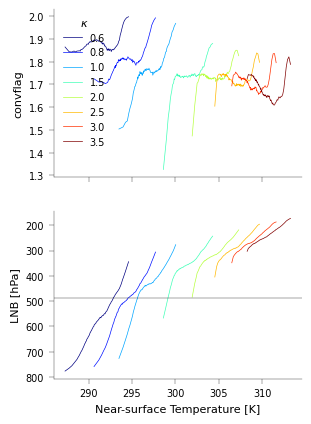

In [189]:
colors_exp = plt.cm.jet(np.linspace(0, 1, n_exp))
save_convflag_fig = False
fig, ax = plt.subplots(2, 1, figsize=(width['one_col'], 2 * width['one_col'] / ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(np.average(temp_quant3[i, ind_surf], axis=0, weights=lat_weights),
               np.average(convflag_quant3[i], axis=0, weights=lat_weights), color=colors_exp[i], label=f'{tau_lw[i]}')
    ax[1].plot(np.average(temp_quant3[i, ind_surf], axis=0, weights=lat_weights),
               lzb(np.average(klzbs_quant3[i], axis=0, weights=lat_weights)), color=colors_exp[i])
ax[1].axhline(pressure_ft_actual/100, color='k', lw=ax_linewidth)
ax[0].legend(title='$\kappa$')
ax[0].set_ylabel('convflag')
ax[-1].set_xlabel('Near-surface Temperature [K]')
ax[1].invert_yaxis()
ax[1].set_ylabel('LNB [hPa]')
# ax.set_ylim(1, 2)
if save_convflag_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/convflag_{region}_{season}_kappa.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

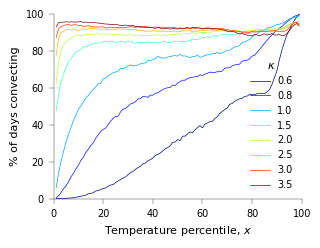

In [190]:
save_convfract_fig = False
fig, ax = plt.subplots(1, 1, figsize=(width['one_col'], width['one_col'] / ar), sharex=True)
for i in range(n_exp):
    ax.plot(quantiles_all, 100 * np.average(convfract_quant3[i], axis=0, weights=lat_weights),
            color=colors_exp[i], label=f'{tau_lw[i]}')
ax.set_xlabel(percentile_label)
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_ylabel('% of days convecting')
ax.legend(title='$\kappa$')
if save_convfract_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/convfract_{region}_{season}_kappa.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [191]:
def get_gradient(temp_quant, temp_av, ref_ind, confidence = 0.9):
    """
    Gets gradient of temperature of given quantile vs average temperature

    Args:
        temp_quant: [n_exp]
        temp_av: [n_exp]
        ref_ind: int
        confidence: float
            Desired confidence in temperature

    Returns:
        float
            Gradient
        [n_exp]
            Predicted temperature for each experiment
        float
            Confidence value for the gradient, such that there is the desired confidence 
            in ± this value about returned gradient.
    """
    fit_func = lambda x, m: temp_quant[ref_ind] + m*(x-temp_av[ref_ind])     # Straight line through the ref point
    param, pcov = scipy.optimize.curve_fit(fit_func,temp_av, temp_quant)[:2]
    # param_with_error = uncertainties.correlated_values(param, pcov)[0]
    # param_std = param_with_error.std_dev
    param_std = np.sqrt(pcov)
    z_score = z_score_from_confidence_interval(confidence)
    return param, fit_func(temp_av, param), z_score * param_std

## Figure 4 of O'Gorman & Schneider 2009
### Tropics
In the plot below, all the gradients are below 1, indicating that the hottest days warm less quickly than the average day. If we look at the largest $\kappa$ values, it is also clear that the gradient here is a lot larger than the gradient at lower $\kappa$ and thus causes the gradients to be larger than maybe they appear by eye.

In [192]:
quant_grad_plot = [1, 25, 50, 75, 99]
quant_grad_plot_ind = numpy_indexed.indices(quantiles_all, quant_grad_plot)
n_quant_grad_plot = len(quant_grad_plot)

tau_lw_ref = 1
tau_ref_ind = np.where(np.asarray(tau_lw)==tau_lw_ref)[0][0]
temp_quant_grad = np.zeros((n_lat, n_quant_grad_plot))
temp_quant_grad_fit = np.zeros((n_exp, n_lat, n_quant_grad_plot))
for i in range(n_lat):
    for j in range(n_quant_grad_plot):
        temp_quant_grad[i, j], temp_quant_grad_fit[:, i, j], _ = \
            get_gradient(temp_quant3[:, ind_surf, i, quant_grad_plot_ind[j]], temp_mean[:, ind_surf, i], tau_ref_ind)

Gradient of best fit line for [1, 25, 50, 75, 99] percentiles: [1.12 1.01 0.99 0.97 0.99]


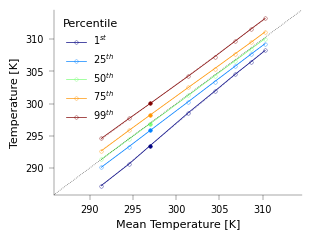

In [193]:
trend_line_on = True
save_trend_fig = False

color_seq_quant = plt.cm.jet(np.linspace(0,1,n_quant_grad_plot))

# labels_quant = [f'{qu}$^{st}$', '25$^{th}$', '50$^{th}$', '75$^{th}$', '99$^{th}$']
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
for j in range(n_quant_grad_plot):
    ax.plot(np.average(temp_mean[:, ind_surf], weights=lat_weights, axis=1),
            np.average(temp_quant3[:, ind_surf, :, quant_grad_plot_ind[j]], weights=lat_weights, axis=1),
            marker='o',
            label=f'{quant_grad_plot[j]}'+ ('$^{st}$' if quant_grad_plot[j]==1 else '$^{th}$'),
            color=color_seq_quant[j], fillstyle='none')
    if trend_line_on:
        # Filled circle for reference simulation
        ax.plot(np.average(temp_mean[:, ind_surf], weights=lat_weights, axis=1)[tau_ref_ind],
                np.average(temp_quant3[:, ind_surf, :, quant_grad_plot_ind[j]], weights=lat_weights, axis=1)[tau_ref_ind],
                marker='o', color=color_seq_quant[j], fillstyle='full')
        if j==n_quant_grad_plot-1:
            label = None #'Linear fits'
        else:
            label = None
        ax.plot(np.average(temp_mean[:, ind_surf], weights=lat_weights, axis=1),
                np.average(temp_quant_grad_fit[:, :, j], axis=1, weights=lat_weights),
                linestyle='--', color=color_seq_quant[j], alpha=0.3, label=label)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
lim_new = [np.asarray([xlim, ylim]).min(), np.asarray([xlim, ylim]).max()]
ax.plot(lim_new, lim_new, 'k:', alpha=0.75)
ax.set_ylim(lim_new)
ax.set_xlim(lim_new)
if trend_line_on:
    ax.legend(loc='upper left', title='Percentile')
ax.set_xlabel(f'Mean Temperature [K]')
ax.set_ylabel(f'Temperature [K]')
if save_fig or save_trend_fig:
    if trend_line_on:
        file_name = f"{region.lower()}_trend"
    else:
        file_name = f"{region.lower()}_no_trend"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf",dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight',
                pad_inches=save_pad_inches)
print(f'Gradient of best fit line for {quant_grad_plot} percentiles: {np.round(np.average(temp_quant_grad, weights=lat_weights, axis=0), 2)}')

## Scaling Factor
Below I combine all simulations to get a scaling factor for temperature covering all simulations. I get both the simulated and theoretical scaling factors.

In [194]:
# Decomposition of temp_adiabat_anom
temp_adiabat_anom_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
temp_ce_mean = np.zeros((n_exp, n_lat))
temp_ce_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
temp_ft_anom_quant3 = np.zeros((n_exp, n_lat, n_quant_all))
z_ft_anom_quant3 = z_quant3 - z_mean[:, :, np.newaxis]
for j in range(n_lat):
    temp_adiabat_anom_quant3[:, j], temp_ce_mean[:, j], temp_ce_quant3[:, j], temp_ft_anom_quant3[:, j] = \
        decompose_temp_adiabat_anomaly(temp_mean[:, ind_surf, j], temp_quant3[:, ind_surf, j], sphum_mean[humid_calc][:, j], 
                                       sphum_quant3[humid_calc][:, j], temp_mean[:, ind_ft, j], temp_quant3[:, ind_ft, j], 
                                       p_surface, pressure_ft_actual)
temp_ce_anom_quant3 = temp_ce_quant3 - temp_ce_mean[:, :, np.newaxis]
temp_adiabat_anom_quant3_z_form = g/lnp_const * z_ft_anom_quant3 - temp_ce_anom_quant3

In [195]:
# delta_temp_quant_theory[-1] will be all zeros and never used, but helpful to keep this shape
delta_temp_quant_theory = {method: np.zeros((n_exp-1, n_lat, n_quant_all)) for method in
                           ['wtg', 'z', 'wtg_no_rh', 'z_no_rh', 'old', 'old_no_rh', 'best', 'best_no_rh', 'new_q', 'new_r']}
delta_temp_quant_theory_cont = {'wtg': {var: np.zeros((n_exp-1, n_lat, n_quant_all)) for var in 
                                ['temp_s_mean', 'rh', 'temp_s_mean_temp_a0', 'temp_a', 'temp_s_mean_temp_ft0', 'temp_ft', 
                                 'temp_s_mean_temp_ce0', 'temp_ce']}}
for method in ['new_q', 'new_r']:
    delta_temp_quant_theory_cont[method] = {var: np.zeros((n_exp-1, n_lat, n_quant_all)) for var in 
                                            ['temp_s', 'humidity', 'r_change', 'temp_a_change', 'temp_ft_change', 'temp_ce_change']}
with tqdm(total=(n_exp-1)*n_lat*(len(delta_temp_quant_theory) - 2), position=0, leave=True) as pbar:
    for i in range(n_exp-1):
        for j in range(n_lat):
            for key in delta_temp_quant_theory:
                if 'old' in key:
                    continue
                if 'best' in key:
                    delta_temp_quant_theory[key][i, j] = \
                        get_delta_temp_quant_theory(temp_mean[i:i+2, ind_surf, j], temp_quant3[i:i+2, ind_surf, j], sphum_mean[humid_calc][i:i+2, j], 
                                                    sphum_quant3[humid_calc][i:i+2, j], p_surface, pressure_ft_actual, None, None, None, None, 
                                                    'squared', 'squared', 'none' if 'no_rh' in key else 'full')[0]
                else:
                    if 'new' in key:
                        delta_temp_quant_theory[key][i, j], info_coef, info_change = \
                            get_delta_temp_quant_theory_simple2(temp_mean[i:i+2, ind_surf, j], temp_quant3[i:i+2, ind_surf, j], 
                                                                sphum_mean[humid_calc][i:i+2, j],
                                                                sphum_quant3[humid_calc][i:i+2, j], p_surface, pressure_ft_actual, 
                                                                ignore_rh=True if 'no_rh' in key else False, 
                                                                use_sphum_anom0=True if 'q' in key else False)
                        for var in ['temp_s', 'humidity', 'r_change', 'temp_a_change']:
                            # Add mean change to each of these so centered around 1 not around 0
                            delta_temp_quant_theory_cont[key][var][i, j] = info_coef[var] * info_change[var] + info_change['temp_s']
                        delta_temp_quant_theory_cont[key]['temp_ce_change'][i, j] = \
                            info_coef['temp_a_change'] * -(temp_ce_anom_quant3[i+1, j] - temp_ce_anom_quant3[i, j]) + info_change['temp_s']
                        delta_temp_quant_theory_cont[key]['temp_ft_change'][i, j] = \
                            info_coef['temp_a_change'] * (temp_ft_anom_quant3[i+1, j] - temp_ft_anom_quant3[i, j]) + info_change['temp_s']
                    if 'z' in key:
                        delta_temp_quant_theory[key][i, j] = \
                            get_delta_temp_quant_theory_simple(temp_mean[i:i+2, ind_surf, j], temp_quant3[i:i+2, ind_surf, j], 
                                                               sphum_mean[humid_calc][i:i+2, j], sphum_quant3[humid_calc][i:i+2, j], p_surface, 
                                                               pressure_ft_actual, temp_mean[i:i+2, ind_ft, j], temp_quant3[i:i+2, ind_ft, j], 
                                                               z_mean[i:i+2, j], z_quant3[i:i+2, j], ignore_rh=True if 'no_rh' in key else False)[0]
                    elif 'wtg' in key:
                        delta_temp_quant_theory[key][i, j], delta_temp_quant_theory[key.replace('wtg', 'old')][i:i+2, j], info_coef, info_change = \
                            get_delta_temp_quant_theory_simple(temp_mean[i:i+2, ind_surf, j], temp_quant3[i:i+2, ind_surf, j], 
                                                               sphum_mean[humid_calc][i:i+2, j], sphum_quant3[humid_calc][i:i+2, j], p_surface,
                                                               pressure_ft_actual, ignore_rh=True if 'no_rh' in key else False)
                        if key == 'wtg':
                            for var in ['temp_s_mean', 'temp_s_mean_temp_a0', 'temp_a']:
                                delta_temp_quant_theory_cont[key][var][i, j] = info_coef[var] * info_change[var]
                            delta_temp_quant_theory_cont[key]['rh'][i, j] = info_coef['r_quant'] * (info_change['r_quant'] - info_change['r_mean'])
                            # Breakdown adiabatic anomaly into ft and ce terms
                            delta_temp_quant_theory_cont[key]['temp_s_mean_temp_ft0'][i, j] = \
                                delta_temp_quant_theory_cont[key]['temp_s_mean_temp_a0'][i, j]/temp_adiabat_anom_quant3[i, j] * temp_ft_anom_quant3[i, j]
                            delta_temp_quant_theory_cont[key]['temp_ft'][i, j] = info_coef['temp_a'] * (temp_ft_anom_quant3[i+1, j] - 
                                                                                                   temp_ft_anom_quant3[i, j])
                            delta_temp_quant_theory_cont[key]['temp_s_mean_temp_ce0'][i, j] = \
                                delta_temp_quant_theory_cont[key]['temp_s_mean_temp_a0'][i, j]/temp_adiabat_anom_quant3[i, j] * -temp_ce_anom_quant3[i, j]
                            delta_temp_quant_theory_cont[key]['temp_ce'][i, j] = info_coef['temp_a'] * -(temp_ce_anom_quant3[i+1, j] - 
                                                                                                   temp_ce_anom_quant3[i, j])
                            for var in delta_temp_quant_theory_cont[key]:
                                if var == 'temp_s_mean':
                                    continue
                                # Add mean change to each of these so centered around 1 not around 0
                                # As interested in scaling factor of each term relative to change in mean.
                                delta_temp_quant_theory_cont[key][var][i, j] = delta_temp_quant_theory_cont[key][var][i, j] + info_change['temp_s_mean']
                pbar.update(1)

# theory3 adds the same theoretical delta_temp to theory prediction of previous kappa so errors accumulate
temp_quant_theory3 = {method: temp_quant3[:, ind_surf].copy() for method in delta_temp_quant_theory}
for method in delta_temp_quant_theory:
    for j in range(n_exp-1):
        temp_quant_theory3[method][1+j] = temp_quant_theory3[method][j] + delta_temp_quant_theory[method][j]
        
temp_quant_theory_cont = {var: temp_quant3[:, ind_surf].copy() for var in delta_temp_quant_theory_cont}
for method in delta_temp_quant_theory_cont:
    temp_quant_theory_cont[method] = {var: temp_quant3[:, ind_surf].copy() for var in delta_temp_quant_theory_cont[method]}
    for var in delta_temp_quant_theory_cont[method]:
        for j in range(n_exp-1):
            temp_quant_theory_cont[method][var][1+j] = temp_quant_theory_cont[method][var][j] + delta_temp_quant_theory_cont[method][var][j]

100%|██████████| 784/784 [00:20<00:00, 38.56it/s]


In [196]:
confidence = 0.9        # desired confidence for shading in plots
sf_tau_use = [np.where(tau_lw<=np.inf)[0], np.where(tau_lw<=1)[0], np.where(tau_lw>=1)[0]]
sf_tau_ref = [tau_lw_ref, tau_lw_ref, tau_lw_ref]
n_sf = len(sf_tau_use)
sf_tau_ref_ind = [np.where(tau_lw[sf_tau_use[i]]==sf_tau_ref[i])[0] for i in range(n_sf)]
sf_labels = ['All $\kappa$', f'$\kappa \leq {tau_lw[sf_tau_use[1]].max()}$', f'$\kappa \geq {tau_lw[sf_tau_use[2]].min()}$']
# all temperatures averaged above x=0 - same as temp_av except for no area averaging
scaling_factor = np.zeros((n_sf, n_lat, n_quant_all))
scaling_factor_error = np.zeros((n_sf, n_lat, n_quant_all))

scaling_factor_theory = {method: np.zeros((n_sf, n_lat, n_quant_all)) for method in delta_temp_quant_theory}
scaling_factor_theory_cont = {method: {var: np.zeros((n_sf, n_lat, n_quant_all)) for var in delta_temp_quant_theory_cont[method]} 
                              for method in delta_temp_quant_theory_cont}
# scaling_factor_theory_cont_new = {var: np.zeros((n_sf, n_lat, n_quant_all)) for var in delta_temp_quant_theory_cont_new}

sf_av = temp_mean[:, ind_surf]

for i in range(n_sf):
    for j in range(n_quant_all):
        # The theory predicts median change but not mean hence I use median rather than mean.
        # This means can get theoretical scale factor rather than using simulated mean.
        # This means x=50 will correspond to y=1 in all plots below.
        # Straight line through the ref point
        for k in range(n_lat):
            scaling_factor[i, k, j], _, scaling_factor_error[i, k, j] = get_gradient(temp_quant3[sf_tau_use[i], ind_surf, k, j],
                                                                                     sf_av[sf_tau_use[i], k], sf_tau_ref_ind[i],
                                                                                     confidence)
            for method in scaling_factor_theory:
                # Use theory2 version for theoretical scaling factor as errors compounded - makes most sense to me
                scaling_factor_theory[method][i, k, j] = get_gradient(temp_quant_theory3[method][sf_tau_use[i], k, j],
                                                           sf_av[sf_tau_use[i], k],
                                                           sf_tau_ref_ind[i], confidence)[0]
            for method in scaling_factor_theory_cont:
                for var in scaling_factor_theory_cont[method]:
                    scaling_factor_theory_cont[method][var][i, k, j] = get_gradient(temp_quant_theory_cont[method][var][sf_tau_use[i], k, j], 
                                                                                    sf_av[sf_tau_use[i], k], sf_tau_ref_ind[i], confidence)[0]     

## Simulated Scaling Factor
Combine simulations to plot the simulated warming of a given percentile as a function of the mean warming.

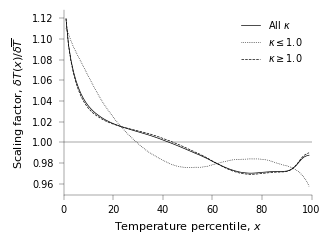

In [197]:
save_sf_fig = False
# if publishing figure, use high dpi
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(quantiles_all, np.average(scaling_factor[0], axis=0, weights=lat_weights), color='k', label=sf_labels[0])
ax.plot(quantiles_all, np.average(scaling_factor[1], axis=0, weights=lat_weights), color='k', linestyle=':',
        label = sf_labels[1])
ax.plot(quantiles_all, np.average(scaling_factor[2], axis=0, weights=lat_weights), color='k', linestyle='--',
        label = sf_labels[2])
ax.hlines(1, 0, 100, lw=ax_linewidth, color='k')
# # Remove some of the lines but keep ylims the same
# ax.lines.pop(1)
# ax.lines.pop(1)
ax.legend()
ax.set_xlim(0,100)
# if quant_type_use == 'x':
#     ax.set_ylim(0.5,1.5)
# else:
#     ax.set_ylim(0.5,2.5)
ax.set_xlabel(percentile_label)
ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
if save_fig or save_sf_fig:
    file_name = f"scaling_factor_multi_kappa_{region.lower()}_{season}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf", dpi=dpi['monochrome'] if publish_fig else low_dpi, 
                bbox_inches='tight', pad_inches=save_pad_inches)

### Tropical Theory
Below I apply the theory developed for the tropics to the extratropics. It predicts the amplified warming of cold days, but is not quantitatively accurate.

Thermodynamic theory assumes $\delta \Delta T_A = \delta \Delta T_{CE}$, while the dynamic theory assumes $\delta \Delta T_A = \delta \Delta T_{FT}$.

In [198]:
scaling_factor_theory['wtg_thermo'] = scaling_factor_theory_cont['wtg']['temp_s_mean'] + scaling_factor_theory_cont['wtg']['rh']-1 + scaling_factor_theory_cont['wtg']['temp_s_mean_temp_a0']-1 + scaling_factor_theory_cont['wtg']['temp_ce']-1
scaling_factor_theory['wtg_dynamic'] = scaling_factor_theory_cont['wtg']['temp_s_mean'] + scaling_factor_theory_cont['wtg']['rh']-1 + scaling_factor_theory_cont['wtg']['temp_s_mean_temp_a0']-1 + scaling_factor_theory_cont['wtg']['temp_ft']-1

for method in ['new_q', 'new_r']:
    scaling_factor_theory[method+'_thermo'] = \
        scaling_factor_theory_cont[method]['temp_s']-1 + scaling_factor_theory_cont[method]['humidity']-1 + \
        scaling_factor_theory_cont[method]['r_change']-1 + scaling_factor_theory_cont[method]['temp_ce_change']-1 + 1
    scaling_factor_theory[method+'_dynamic'] = \
        scaling_factor_theory_cont[method]['temp_s']-1 + scaling_factor_theory_cont[method]['humidity']-1 + \
        scaling_factor_theory_cont[method]['r_change']-1 + scaling_factor_theory_cont[method]['temp_ft_change']-1 + 1

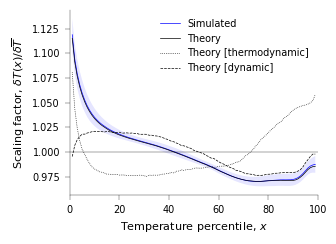

In [199]:
# Do a single plot combining all simulations
sf_ind_use = 0  # 0, 1 or 2
save_sf_theory_fig = True
# if publishing figure, use high dpi
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quantiles_all, np.average(scaling_factor[sf_ind_use], axis=0, weights=lat_weights), color='b', label='Simulated')
# ax.plot(quantiles_all, np.average(scaling_factor_theory['wtg'][sf_ind_use], axis=0, weights=lat_weights), color='k', 
#         label='Theory')
# ax.plot(quantiles_all, np.average(scaling_factor_theory['wtg_thermo'][sf_ind_use], axis=0, weights=lat_weights), color='k',
#         linestyle=':', label='Theory [thermodynamic]')
# ax.plot(quantiles_all, np.average(scaling_factor_theory['wtg_dynamic'][sf_ind_use], axis=0, weights=lat_weights), color='k',
#         linestyle='--', label='Theory [dynamic]')
# ax.plot(quantiles_all, np.average(scaling_factor_theory['new_q'][sf_ind_use], axis=0, weights=lat_weights), color='r')
# ax.plot(quantiles_all, np.average(scaling_factor_theory['new_q_thermo'][sf_ind_use], axis=0, weights=lat_weights), color='r',
#         linestyle=':')
# ax.plot(quantiles_all, np.average(scaling_factor_theory['new_q_dynamic'][sf_ind_use], axis=0, weights=lat_weights), color='r',
#         linestyle='--')
ax.plot(quantiles_all, np.average(scaling_factor_theory['new_r'][sf_ind_use], axis=0, weights=lat_weights), color='k', label='Theory')
ax.plot(quantiles_all, np.average(scaling_factor_theory['new_r_thermo'][sf_ind_use], axis=0, weights=lat_weights), color='k',
        linestyle=':', label='Theory [thermodynamic]')
ax.plot(quantiles_all, np.average(scaling_factor_theory['new_r_dynamic'][sf_ind_use], axis=0, weights=lat_weights), color='k',
        linestyle='--', label='Theory [dynamic]')
# Add error
ax.fill_between(quantiles_all, np.average(scaling_factor[sf_ind_use]-scaling_factor_error[sf_ind_use], axis=0, weights=lat_weights), 
                np.average(scaling_factor[sf_ind_use]+scaling_factor_error[sf_ind_use], axis=0, weights=lat_weights), fc='b', alpha=0.1)
ax.hlines(1, 0, 100, linewidth=ax_linewidth, color='k')
ax.legend()
ax.set_xlim(0,100)
ax.set_xlabel(percentile_label)
ax.set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
if save_fig or save_sf_theory_fig:
    file_name = f"scaling_factor_theory_{region.lower()}_{season}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf",dpi=dpi['combination'] if publish_fig else low_dpi, 
                bbox_inches='tight', pad_inches=save_pad_inches)

In [200]:
ind_min_sf = np.average(scaling_factor[sf_ind_use], axis=0, weights=lat_weights).argmax()
print(quantiles_all[ind_min_sf])
print(np.average(scaling_factor[sf_ind_use], axis=0, weights=lat_weights)[ind_min_sf])
print(np.average(scaling_factor_error[sf_ind_use], axis=0, weights=lat_weights)[ind_min_sf])

1
1.118978498440438
0.016583510694459614


## Breakdown contribution to Theory
Below, in the top plot, I show the scaling factor contribution of each term in the most simple version of the theory.

In the second plot, I show how the adiabatic temperature anomaly contribution is split up into convective and free tropospheric parts.

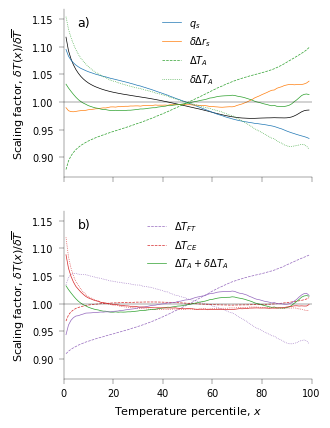

In [201]:
colors_breakdown = {'temp_s_mean': default_colors[0], 'rh': default_colors[1], 'temp_s_mean_temp_a0': default_colors[2], 'temp_a': default_colors[2], 
                    'temp_s_mean_temp_ft0': default_colors[4], 'temp_ft': default_colors[4], 
                    'temp_s_mean_temp_ce0': default_colors[3], 'temp_ce': default_colors[3]}
sf_cont_use = scaling_factor_theory_cont['wtg']
linestyles_breakdown = {key: '--' if '0' in key else ':' for key in sf_cont_use}
linestyles_breakdown['temp_s_mean'] = '-'
linestyles_breakdown['rh'] = '-'
labels_breakdown = {'temp_s_mean': '$q_{s}$', 'rh': '$\delta \Delta r_s$',
                    'temp_s_mean_temp_a0': '$\Delta T_A$', 'temp_a': '$\delta \Delta T_A$', 
                    'temp_s_mean_temp_ft0': '$\Delta T_{FT}$', 'temp_ft': None, 'temp_s_mean_temp_ce0': '$\Delta T_{CE}$', 'temp_ce': None}

save_sf_theory_breakdown_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True, sharey=True)
ax[0].plot(quantiles_all, np.average(scaling_factor_theory['wtg'][sf_ind_use], axis=0, weights=lat_weights), color='k')
for i, key in enumerate(sf_cont_use):
    if ('ft' in key) or ('ce' in key):
        ax[1].plot(quantiles_all, np.average(sf_cont_use[key][sf_ind_use], axis=0, weights=lat_weights), color=colors_breakdown[key],
            linestyle=linestyles_breakdown[key], label=labels_breakdown[key])
        if 'temp_a' not in key:
            continue
    ax[0].plot(quantiles_all, np.average(sf_cont_use[key][sf_ind_use], axis=0, weights=lat_weights), color=colors_breakdown[key],
            linestyle=linestyles_breakdown[key], label=labels_breakdown[key])
for i in range(2):
    ax[i].plot(quantiles_all, np.average(sf_cont_use['temp_a'][sf_ind_use] + 
                                         sf_cont_use['temp_s_mean_temp_a0'][sf_ind_use] - 1, axis=0, weights=lat_weights),
               color=colors_breakdown['temp_a'], label='$\Delta T_A + \delta \Delta T_A$' if i==1 else None)
    ax[i].axhline(1, color='k', lw=ax_linewidth)
    ax[i].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
for var in ['ft', 'ce']:
    ax[1].plot(quantiles_all, np.average(sf_cont_use['temp_'+var][sf_ind_use] + 
                                         sf_cont_use['temp_s_mean_temp_'+var+'0'][sf_ind_use] - 1, axis=0, weights=lat_weights),
               color=colors_breakdown['temp_'+var])
ax[0].legend()
ax[1].legend()
ax[0].set_xlim(0,100)
ax[1].set_xlabel(percentile_label)
label_subplots(fig, ax)
# ax[0].set_ylim(0.85, 1.15)

if save_fig or save_sf_theory_breakdown_fig:
    file_name = f"scaling_factor_theory_breakdown_{region.lower()}_{season}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf",dpi=dpi['combination'] if publish_fig else low_dpi, 
                bbox_inches='tight', pad_inches=save_pad_inches)

### New Theory
Below, I do a split for the new theory - no $\Delta T_A$ term.

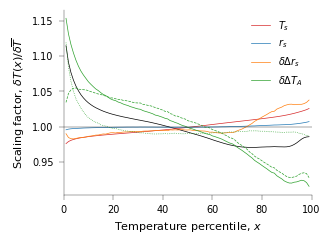

In [202]:
colors_breakdown = {'temp_s': default_colors[3], 'humidity': default_colors[0],  
                    'r_change': default_colors[1], 'temp_a_change': default_colors[2], 
                    'temp_ce_change': default_colors[2], 'temp_ft_change': default_colors[2]}
# humidity_use = 'q'
humidity_use = 'r'
sf_cont_use = scaling_factor_theory_cont['new_'+humidity_use]
linestyles_breakdown = {key: '-' for key in sf_cont_use}
linestyles_breakdown['temp_ce_change'] = ':'
linestyles_breakdown['temp_ft_change'] = '--'
labels_breakdown = {'temp_s': '$T_s$', 'humidity': f'${humidity_use}_s$', 'r_change': '$\delta \Delta r_s$',
                    'temp_a_change': '$\delta \Delta T_A$',
                    'temp_ce_change': None, 'temp_ft_change': None}

save_sf_theory_breakdown_new_fig = True
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True, sharey=True)
ax = [ax]
ax[0].plot(quantiles_all, np.average(scaling_factor_theory['new_'+humidity_use][sf_ind_use], axis=0, weights=lat_weights), color='k')
for i, key in enumerate(sf_cont_use):
    # if ('ft' in key) or ('ce' in key):
    #     ax[0].plot(quantiles_all, np.average(scaling_factor_theory_cont_new[key][sf_ind_use], axis=0, weights=lat_weights), 
    #                color=colors_breakdown[key], linestyle=linestyles_breakdown[key], label=None)
    #     if 'temp_a' not in key:
    #         continue
    ax[0].plot(quantiles_all, np.average(sf_cont_use[key][sf_ind_use], axis=0, weights=lat_weights), color=colors_breakdown[key],
            linestyle=linestyles_breakdown[key], label=labels_breakdown[key])
for i in range(len(ax)):
    ax[i].axhline(1, color='k', lw=ax_linewidth)
    ax[i].set_ylabel('Scaling factor, $\delta T(x)/\delta \overline{T}$')
    ax[i].legend()
ax[0].set_xlim(0,100)
ax[-1].set_xlabel(percentile_label)
if len(ax)>1:
    label_subplots(fig, ax)
# ax[0].set_ylim(0.85, 1.15)

if save_fig or save_sf_theory_breakdown_new_fig:
    file_name = f"scaling_factor_theory_breakdown_new_{humidity_use}_{region.lower()}_{season}"
    fig.savefig(f"/Users/joshduffield/Desktop/{file_name}.pdf",dpi=dpi['combination'] if publish_fig else low_dpi, 
                bbox_inches='tight', pad_inches=save_pad_inches)

### $\Delta T_A$ for each simulation
To help understand the bottom plot above, I see how $T_{CE}(x)$ and $\Delta T_{FT}(x)$ vary with warming below.

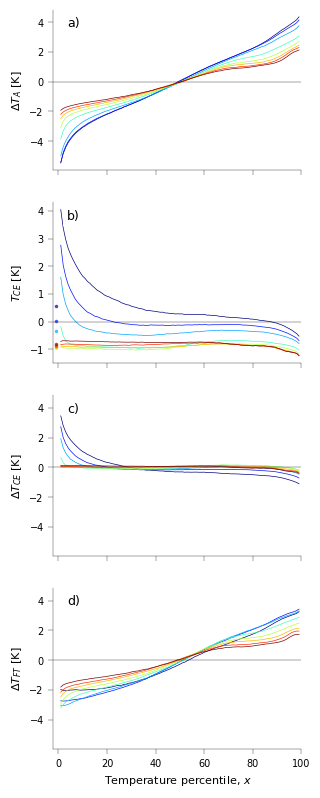

In [203]:
save_temp_adiabat_fig = False
use_temp_adiabat_z_form = False
color_seq_exp = plt.cm.jet(np.linspace(0,1,n_exp))

fig, ax = plt.subplots(4,1, figsize=(width['one_col'], 4*width['one_col']/ar), sharex=True)
ax[0].sharey(ax[2])
ax[2].sharey(ax[3])
for i in range(n_exp):
    if use_temp_adiabat_z_form:
        ax[0].plot(quantiles_all, np.average(temp_adiabat_anom_quant3_z_form[i], axis=0, weights=lat_weights), color=color_seq_exp[i],
                   label=f'{tau_lw[i]}')
        ax[3].plot(quantiles_all, g/lnp_const * np.average(z_ft_anom_quant3[i], axis=0, weights=lat_weights), color=color_seq_exp[i])
    else:
        ax[0].plot(quantiles_all, np.average(temp_adiabat_anom_quant3[i], axis=0, weights=lat_weights), color=color_seq_exp[i], 
                   label=f'{tau_lw[i]}')
        ax[3].plot(quantiles_all, np.average(temp_ft_anom_quant3[i], axis=0, weights=lat_weights), color=color_seq_exp[i])
    ax[1].plot(quantiles_all, np.average(temp_ce_quant3[i], axis=0, weights=lat_weights), color=color_seq_exp[i])
    ax[1].scatter(-1, np.average(temp_ce_mean[i], axis=0, weights=lat_weights), marker='o', alpha=0.7, edgecolors=None,
                  facecolors=color_seq_exp[i], lw=0)
    ax[2].plot(quantiles_all, np.average(temp_ce_quant3[i]-temp_ce_mean[i, :, np.newaxis], axis=0, weights=lat_weights), color=color_seq_exp[i])
for i in range(len(ax)):
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(-2, 100)
ax[1].set_ylabel('$T_{CE}$ [K]')
ax[2].set_ylabel('$\Delta T_{CE}$ [K]')
if use_temp_adiabat_z_form:
    ax[0].set_ylabel("$\Delta T_A'$ [K]")
    ax[3].set_ylabel('$\\frac{g}{R^{\dagger}}\Delta z_{FT}$ [K]')
else:
    ax[0].set_ylabel('$\Delta T_A$ [K]')
    ax[3].set_ylabel('$\Delta T_{FT}$ [K]')
ax[-1].set_xlabel(percentile_label)
label_subplots(fig, ax)
# ax[0].legend(title='$\kappa$', fontsize=4.5, loc='lower right')
if save_fig or save_temp_adiabat_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_adiabat_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

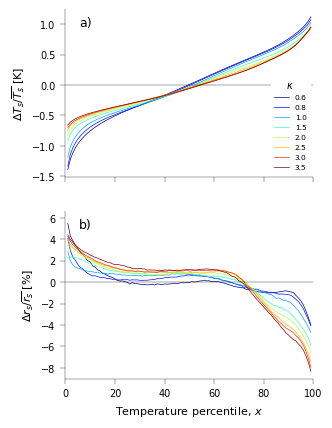

In [204]:
save_near_surf_anom_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 2*width['one_col']/ar), sharex=True)
for i in range(n_exp):
    ax[0].plot(quantiles_all, 100*np.average((temp_quant3[i, ind_surf]-temp_mean[i, ind_surf, :, np.newaxis])/temp_mean[i, ind_surf, :, np.newaxis], axis=0, weights=lat_weights),
               color=color_seq_exp[i], label=f'{tau_lw[i]}' )
    ax[1].plot(quantiles_all, 100*np.average(r_anom_quant3[humid_calc][i]/r_mean[humid_calc][i, :, np.newaxis], axis=0, weights=lat_weights),
               color=color_seq_exp[i], label=f'{tau_lw[i]}')
for i in range(len(ax)):
    ax[i].axhline(0, color='k', lw=ax_linewidth)
ax[-1].set_xlabel(percentile_label)
ax[0].set_ylabel("$\Delta T_s/\overline{T_s}$ [K]")
ax[1].set_ylabel("$\Delta r_s/\overline{r_s}$ [%]")
ax[0].legend(fontsize=5.4, title='$\kappa$', frameon=True, framealpha=1, edgecolor='white',title_fontsize=7, loc='lower right')
ax[1].set_ylim([ax[1].get_ylim()[0], ax[1].get_ylim()[1]+0.5])
ax[0].set_xlim(0, 100)
label_subplots(fig, ax)

if save_fig or save_near_surf_anom_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/surface_anomalies_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)